In [21]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import torch
from data.dataset import Observation

In [22]:
num_entries = 50000
X_MIN = -4
X_MAX = 4
NUM_DIMS = 3

In [23]:
def prob_func(x: list[float]) -> np.ndarray:
    top = abs(np.sum([(abs(X_MIN)+1)*(abs(X_MAX)+1) for dim in x]))
    p0 = abs(np.sum([(dim+1)*(dim+1) for dim in x]))/top
    p = [p0, 1-p0]
    p /= sum(p)
    return p

def val_func(x: list[float]) -> np.ndarray:
    # returns array of y values. each y value is a function f(y_i) = (x_1, ..., x_n)
    val = float(np.random.choice([0,1], size=1, p=prob_func(x)))
    return val
    # val = np.array([(dim+1)*(dim+1) for dim in x])
    # return np.mean(val)

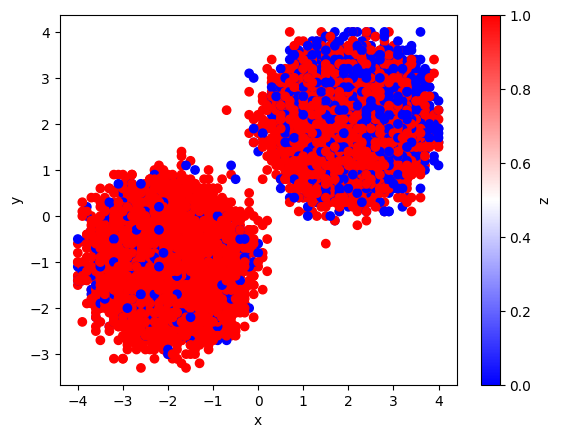

In [53]:
data_x = np.ndarray(shape=(num_entries, NUM_DIMS))
data_x_1 = np.ndarray(shape=(int(num_entries/2), NUM_DIMS))
data_x_2 = np.ndarray(shape=(int(num_entries/2), NUM_DIMS))
data_x_1[:,0] = np.around(np.random.normal(-2,0.6,int(num_entries/2)), decimals=1)
data_x_1[:,1] = np.around(np.random.normal(-1,0.6,int(num_entries/2)), decimals=1)
data_x_1[:,2] = np.around(np.random.triangular(-4,-1,4,int(num_entries/2)), decimals=1)
data_x_2[:,0] = np.around(np.random.normal(2, 0.6, int(num_entries/2)), decimals=1)
data_x_2[:,1] = np.around(np.random.normal(2, 0.6, int(num_entries/2)), decimals=1)
data_x_2[:,2] = np.around(np.random.triangular(-4,3,4,int(num_entries/2)), decimals=1)
data_x = np.concatenate((data_x_1, data_x_2), axis=0)
data_x = np.where(data_x > X_MAX, np.full(data_x.shape, X_MAX), data_x)
data_x = np.where(data_x < X_MIN, np.full(data_x.shape, X_MIN), data_x)
data_y = [val_func(x) for x in data_x]
def plot(data_x, data_y, cmap = "gist_rainbow"):
    fig, ax = plt.subplots()
    scat = ax.scatter(x=data_x[:,0], y=data_x[:,1], c=data_y, cmap=cmap)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    fig.colorbar(scat, ax=ax, label='z')
plot(data_x=data_x, data_y=data_y, cmap="bwr")

In [54]:
def aggregate_by(data_y: torch.tensor, meta: list[Observation]):
    def get_entries(indices):
        return torch.index_select(data_y, 0, torch.tensor(indices))

    def aggregate(entries: torch.tensor):
        return entries.mean(axis=0)

    obs_y = torch.stack([aggregate(get_entries(obs.entries_indices)) for obs in meta]).float()
    return obs_y


In [55]:
def generate_independent_observations(data_y: torch.tensor, num_observations: int) -> list[
    torch.tensor, list[Observation]]:
    # returned data_y is a tensor shaped (entries, values)
    entry_no = len(data_y)
    meta = np.linspace(0, entry_no, entry_no, endpoint=False, dtype=int)
    np.random.shuffle(meta)
    meta = np.array_split(meta, num_observations)
    meta = [Observation(x, i) for i, x in enumerate(meta)]

    obs_y = aggregate_by(data_y, meta)
    return [obs_y, meta]

In [56]:
def generate_dependent_observations(data_x: torch.tensor, data_y: torch.tensor, num_observations: int, dims:int) -> list[torch.tensor, list[Observation]]:
    # returned data_y is a tensor shaped (entries, values)
    meta = np.linspace(X_MIN, X_MAX, abs(X_MAX - X_MIN) * 10 + 1, endpoint=True, dtype=float)

    aggregation_masks = [torch.ones(num_entries, dtype=torch.bool)]
    for dim in dims:
        new_aggregation_masks = []
        for mask in aggregation_masks:
            for prev, curr in zip(meta, meta[1:]):
                dim_mask = torch.logical_and((data_x[:, dim] <= curr), (data_x[:, dim] >= prev))
                aggregation_mask = torch.logical_and(dim_mask, mask)
                new_aggregation_masks.append(aggregation_mask)
            aggregation_masks = new_aggregation_masks
    aggregation_indices = [mask.nonzero(as_tuple=True)[0] for mask in aggregation_masks]
    meta = [indices.numpy().tolist() for indices in aggregation_indices if indices.numel() != 0]
    # meta = [torch.logical_and((data_x[:, dims] <= curr), (data_x[:, dims] >= prev)).nonzero(as_tuple=True)[0] for prev, curr in
    #         zip(meta, meta[1:])]
    # meta = [obs.numpy().tolist() for obs in meta if obs.size(dim=0)]
    meta = [Observation(x, i) for i, x in enumerate(meta)]

    obs_y = aggregate_by(data_y, meta)

    return [obs_y, meta]

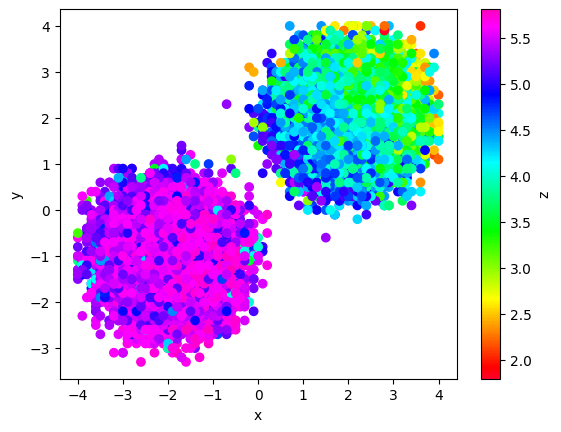

In [57]:
import itertools
def get_data_y(data_x, data_y, dims: list[int], num_observations=10):
    data_x = torch.tensor(data_x)
    data_y = torch.tensor(data_y)
    obs_y, meta = generate_dependent_observations(data_x, data_y, num_observations=num_observations, dims=dims)
    for obs in meta:
        for index in obs.entries_indices:
            data_y[index] = obs_y[obs.value_vec_index]
    return data_y.numpy()
test_y = np.zeros(np.array(data_y).shape)
for dim in range(NUM_DIMS):
    test_y += get_data_y(data_x, data_y, [dim])
for dim_ab in list(itertools.combinations(range(NUM_DIMS), 2)):
    test_y += get_data_y(data_x, data_y, list(dim_ab))
plot(data_x=data_x, data_y=test_y)

In [58]:
import pandas as pd

labels = ["z"]
allfeatures = ["attr_" + str(i) for i in range(0,2)]


def aggregate_on_features(features, mincount, data):
    df = data[labels + features]
    df["c"] = 1
    df = df.groupby(features).sum().reset_index()
    df = df[df.c > mincount].copy()
    return df

def aggregate_on_all_pairs(
    allfeatures,
    data,
    mincount=0,
    gaussian_sigma=None,
):
    allpairsdf = pd.DataFrame()
    for f0 in allfeatures:
        feature_1_id = int(f0.split("_")[-1])
        for f1 in allfeatures:
            feature_2_id = int(f1.split("_")[-1])
            if not feature_1_id < feature_2_id:
                continue
            print("aggregating on", f0, f1)
            features = [f0, f1]
            df = aggregate_on_features(features, mincount, data)
            df["feature_1_id"] = feature_1_id
            df["feature_2_id"] = feature_2_id
            df = df.rename(
                {
                    features[0]: "feature_1_value",
                    features[1]: "feature_2_value",
                },
                axis=1,
            )
            allpairsdf = pd.concat([allpairsdf, df])
    if gaussian_sigma is not None:
        allpairsdf["c"] += np.random.normal(0, gaussian_sigma, len(allpairsdf))
        allpairsdf["click"] += np.random.normal(0, gaussian_sigma, len(allpairsdf))
        allpairsdf["sale"] += np.random.normal(0, gaussian_sigma, len(allpairsdf))
    return allpairsdf

def aggregate_on_all_single(
    allfeatures, data, mincount=0, gaussianSigma=None
):
    allpairsdf = pd.DataFrame()
    for f0 in allfeatures:
        print("aggregating on", f0)

        features = [f0]
        df = aggregate_on_features(features, mincount, data)
        df["feature_1_id"] = int(f0.split("_")[-1])
        df = df.rename({features[0]: "feature_1_value"}, axis=1)
        allpairsdf = pd.concat([allpairsdf, df])
    if gaussianSigma is not None:
        allpairsdf["c"] += np.random.normal(0, gaussianSigma, len(allpairsdf))
        allpairsdf["click"] += np.random.normal(0, gaussianSigma, len(allpairsdf))
        allpairsdf["sale"] += np.random.normal(0, gaussianSigma, len(allpairsdf))
    return allpairsdf

data = pd.DataFrame()
for i, f in enumerate(allfeatures):
    data[f] = np.array(data_x)[:, i]
for i, l in enumerate(labels):
    data[l] = np.array(data_y).reshape((len(data_y), len(labels)))[:, i]
aggregates_single = aggregate_on_all_single(allfeatures, data=data)
aggregates_pairs = aggregate_on_all_pairs(allfeatures, data=data, mincount=4)

aggregating on attr_0
aggregating on attr_1
aggregating on attr_0 attr_1


C:\Users\Zerafoth\AppData\Local\Temp\ipykernel_128928\3509210832.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["c"] = 1


In [59]:
aggregates_pairs

,feature_1_value,feature_2_value,z,c,feature_1_id,feature_2_id
60,-3.6,-0.7,4.0,5,0,1
75,-3.5,-1.4,5.0,6,0,1
76,-3.5,-1.3,6.0,6,0,1
78,-3.5,-1.1,4.0,5,0,1
79,-3.5,-1.0,6.0,6,0,1
...,...,...,...,...,...,...
2302,3.5,1.3,5.0,7,0,1
2303,3.5,1.4,1.0,6,0,1
2306,3.5,1.7,1.0,5,0,1
2313,3.5,2.4,3.0,6,0,1


In [60]:
import networkx as nx
class TestDataGraph(nx.Graph):
    def __init__(self):
        super().__init__(self)

    def prep(self, data_singles, data_pairs):
        single_stats = {}
        for entry in data_singles:
            feature_value, clicks, count, feature_id = entry
            node = f"attr_{int(feature_id)}_val_{feature_value}"
            single_stats[node] = {"count": float(count), "clicks": float(clicks)}

        for entry in data_pairs:
            feature_1_value, feature_2_value, clicks, count, feature_1_id, feature_2_id = entry
            node_a = f"attr_{int(feature_1_id)}_val_{feature_1_value}"
            node_b = f"attr_{int(feature_2_id)}_val_{feature_2_value}"
            self.add_node(node_a, count=single_stats[node_a]["count"], clicks=single_stats[node_a]["clicks"])
            self.add_node(node_b, count=single_stats[node_b]["count"], clicks=single_stats[node_b]["clicks"])
            self.add_edge(node_a, node_b, count=float(count), clicks=float(clicks))

100%|██████████| 50000/50000 [13:30<00:00, 61.68it/s]


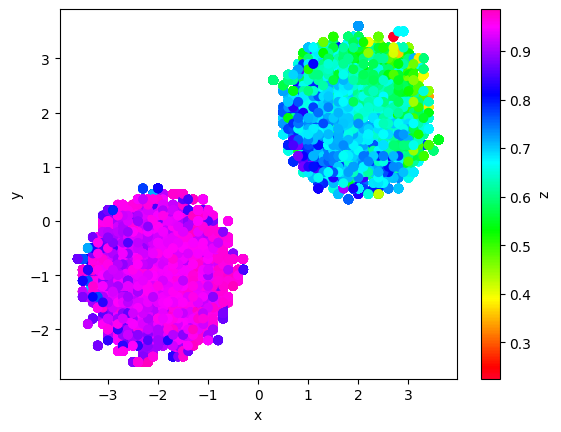

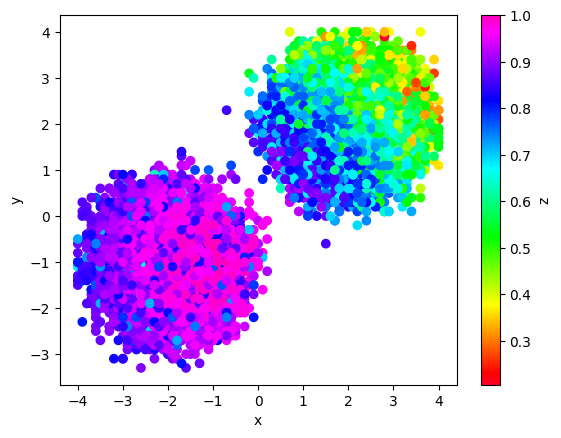

In [61]:
from data.data_generator import DataGenerator
from data.ctr_normalize import CTRNormalize
from tqdm import tqdm

data_graph = TestDataGraph()
data_graph.prep(data_singles=aggregates_single.to_numpy(), data_pairs=aggregates_pairs.to_numpy())
DG = DataGenerator(data_graph=data_graph, ctr_normalize=CTRNormalize.no_action, no_attributes=len(allfeatures))

data_yp = [prob_func(x)[1] for x in data_x]
gen_data_x = []
gen_data_y = []
for i in tqdm(range(num_entries)):
    x, y = DG.generate_entry()
    gen_data_x.append([float(entry) for entry in x])
    gen_data_y.append(float(y))
plot(data_x=np.array(gen_data_x), data_y=np.array(gen_data_y))
plot(data_x=np.array(data_x), data_y=np.array(data_yp))